In [1]:
# this is the pipeline of phenotype analysis
import sys
sys.path.append('..')
import os
import pandas as pd
import copy
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import tree_util

In [2]:
def fr(d_df, profile, sname):
    sp_list = list(profile.columns)
    sp_d_df = d_df.loc[sp_list, sp_list]
    #print(profile)
    sp_profile = np.array(profile.loc[sname, sp_list])
    value = np.dot(sp_profile.reshape(len(sp_profile), 1),sp_profile.reshape(1, len(sp_profile)))
    width = value.shape[0]
    cor_df = np.ones(shape=(width, width)) - sp_d_df.values
    for i in range(width):
        cor_df[i][i] = 0
    value = np.multiply(value, cor_df)
    df = pd.DataFrame(data= value, index=sp_list, columns=sp_list)
    return df

def nfr(d_df, profile, sname):
    sp_list = list(profile.columns)
    n = len(sp_list)
    corr = np.ones(shape=(n, n)) - d_df.loc[sp_list, sp_list].values
    np.fill_diagonal(corr, 0)
    # print(corr[1, 1])
    a = np.array(profile.loc[sname, sp_list])
    inter_matrix = np.dot(a.reshape(len(a), 1),a.reshape(1, len(a)))
    np.fill_diagonal(inter_matrix, 0)
    td = np.sum(inter_matrix)/2
    fr = np.sum(np.multiply(inter_matrix, corr))/2
    fd = np.sum(np.multiply(inter_matrix, d_df.loc[sp_list, sp_list].values))/2
    if td == 0:
        return 0
    return fr/td
    return fr

def multisample_nfr(profile, d_df, node_leaves):
    result = pd.DataFrame(index=profile.index, columns=(list(node_leaves.keys()) + ['nroot']))
    for sname in profile.index:
       for node, sp_list in node_leaves.items():
           sp_list = list(set(sp_list).intersection(set(profile.columns)))
           selected_d = d_df.loc[sp_list, sp_list]
           selected_profile = profile.loc[:, sp_list]
           value = nfr(selected_d, selected_profile, sname)
           result.loc[sname, node] = value
    return result


In [3]:
outdir = '../result/FMT/FR/FMT1'
if not os.path.exists(outdir):
    os.makedirs(outdir)
with open('../result/GCN_fix_tree/renamed_GCN_tree.newick') as fp:
    newick_tree = fp.read()
    # newick_tree = newick_tree.replace('-', '_')

json_tree = tree_util.parse(newick_tree)
largest = {'largest': 0}
leaf_list, l = tree_util.recu_compute(json_tree, 0, largest)
largest_level = largest['largest']
nlayer = largest_level
layer_leaves_dict = tree_util.make_layer_dict(nlayer)
tree_util.recu_layer(json_tree, layer_leaves_dict)
tree_util.to_layer_leaves(layer_leaves_dict, nlayer)
leaves_dict = copy.deepcopy(layer_leaves_dict)
parent_dict = {}
tree_util.parents(json_tree, parent_dict)
node_leaves = {}
for level in layer_leaves_dict.keys():
    for node, sp_list in layer_leaves_dict[level].items():
        if node in node_leaves.keys():
            continue
        node_leaves[node] = copy.deepcopy(sp_list)
subtree_nodes = {}
for l in leaf_list:
    parent = parent_dict[l]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent].append(l)

for node in node_leaves.keys():
    parent = parent_dict[node]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent] += subtree_nodes[node]
    subtree_nodes[parent].append(node)

for node in subtree_nodes.keys():
    subtree_nodes[node].append(node)

direct_children_dict = {}
for node, parent in parent_dict.items():
    if parent not in direct_children_dict:
        direct_children_dict[parent] = []
    direct_children_dict[parent].append(node)

node_leaves['root'] = copy.deepcopy(leaf_list)

In [4]:
d_df = pd.read_csv('../data/sp_d.tsv', sep='\t', header=0, index_col=0)
metadata = pd.read_csv('../data/FMT/FMT1/metadata.tsv', sep='\t', index_col=None, header=0)
abd = pd.read_csv('../data/FMT/FMT1/fmt_abd.tsv', sep='\t', header=0, index_col=0)
name_dict = {}
for sp in d_df.columns:
        name_dict[sp] = sp.replace('_', '-')
d_df = d_df.rename(columns=name_dict, index=name_dict)
abd = abd.rename(columns=name_dict)
sub_ids = ['FAT_006', 'FAT_015', 'FAT_008', 'FAT_020', 'FAT_012']
days = [0, 2, 14, 42, 84]
frac_df = pd.read_csv('../data/FMT/FMT1/Li.txt', sep='\t', header=0, index_col=0)
param = 0.5

In [5]:
profile = abd[list(set(abd.columns).intersection(set(d_df.columns)))]/100
rename_dict = {}
ids = []
for id in sub_ids:
    sid = "{}-22-0-0".format(id)
    ids.append(sid)
    rename_dict[sid] = 'FMT{}'.format(len(ids))
profile = profile.loc[ids, ].rename(index=rename_dict)
profile.to_csv(os.path.join(outdir, 'abd.tsv'), sep='\t')
se_df = multisample_nfr(profile, d_df, node_leaves)
se_df = se_df.T

In [6]:
p_cutoff = 0.05
# compute frac and t
tmp = 'Fraction of donor specific strains ({} days post FMT)'
frac = []
t = []
for day in days:
    if day == 0:
        continue
    post_day = tmp.format(day)
    frac += list(frac_df[post_day])
    t += [day] * len(frac_df)

odf = pd.DataFrame(columns=['F-pvalue', 'nfr_co', 't_co', 'const_co', 'nfr_p', 't_p', 'const_p'])
for node in node_leaves.keys():
    df = pd.DataFrame()
    se = list(se_df.loc[node, ])
    se_vector = []
    for day in days:
        if day == 0:
            continue
        se_vector += se
    if sum(se) == 0:
        continue
    df = pd.DataFrame()
    df['frac'] = frac
    df['nfr'] = se_vector
    df['t'] = t
    X = df[['nfr', 't']]
    y = df['frac']
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    result = model.fit()

    odf.loc[node, 'F-pvalue'] = result.f_pvalue
    for var in result.pvalues.index:
        odf.loc[node, "{}_co".format(var)] = result.params[var]
        odf.loc[node, "{}_p".format(var)] = result.pvalues[var]

In [7]:
odf[odf['F-pvalue'] < p_cutoff]

,F-pvalue,nfr_co,t_co,const_co,nfr_p,t_p,const_p
cluster_S1-C3,0.044831,-3.102795,-0.000777,1.943703,0.018739,0.400533,0.007591


<ipython-input-8-445f5a9ee3bd>:87: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
<ipython-input-8-445f5a9ee3bd>:87: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
<ipython-input-8-445f5a9ee3bd>:87: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
<ipython-input-8-445f5a9ee3bd>:87: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
<ipython-input-8-445f5a9ee3bd>:87: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
<ipython-input-8-445f5a9ee3bd>:87: UserWarning: Tight layout not 

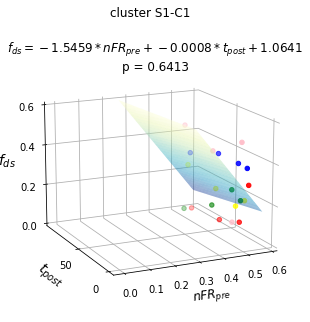

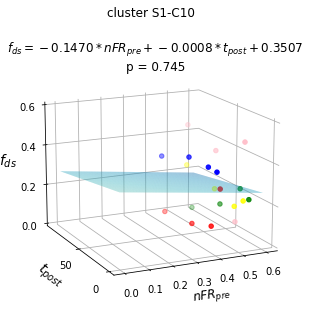

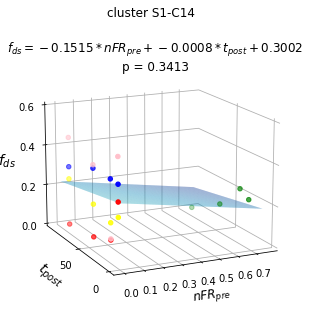

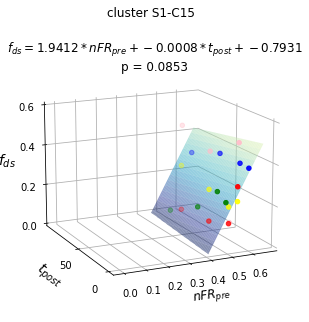

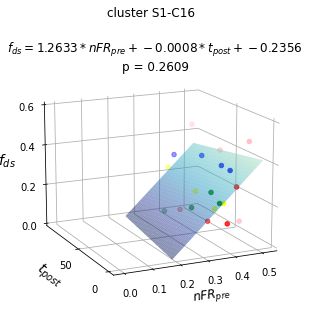

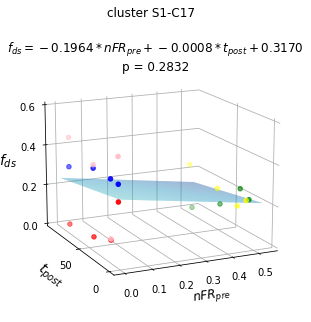

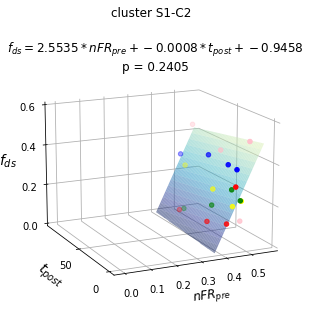

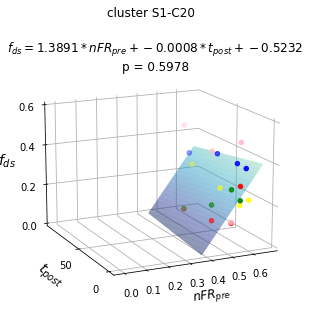

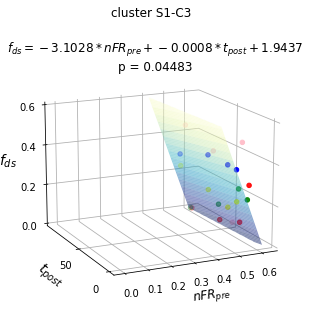

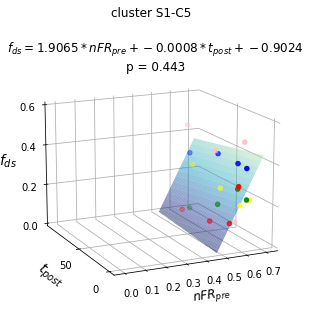

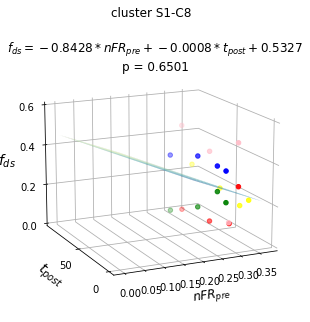

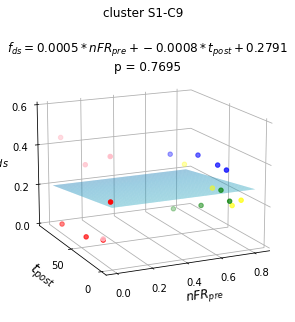

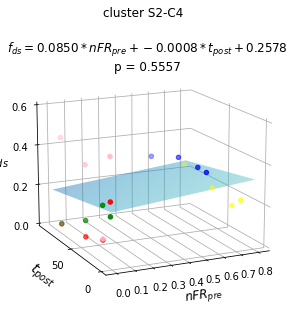

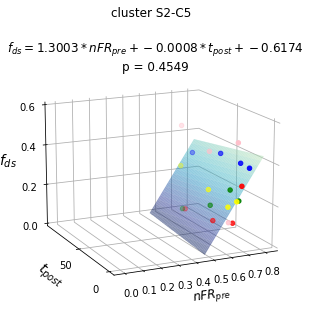

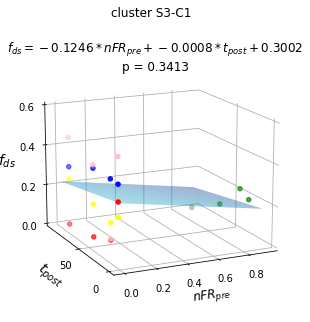

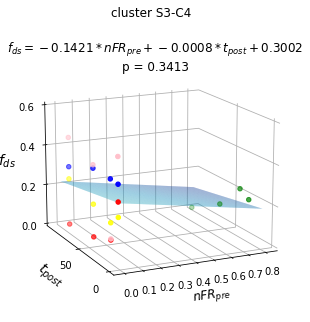

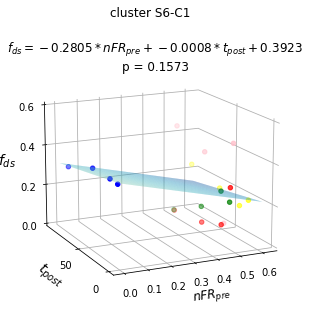

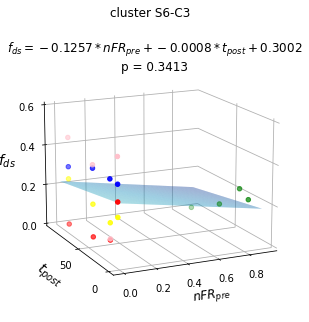

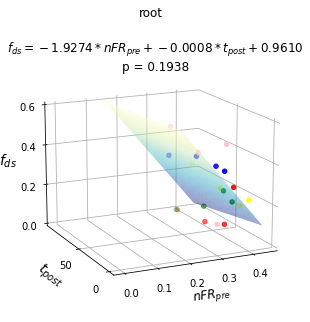

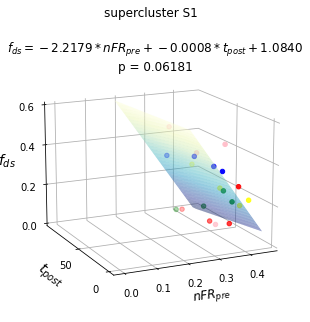

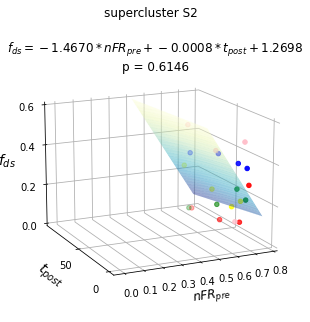

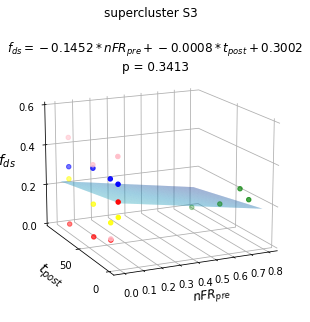

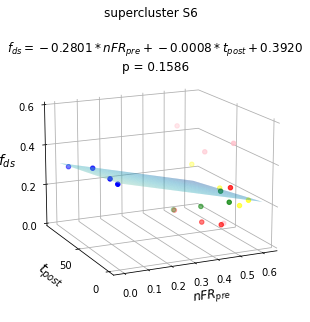

In [8]:
color_dict = {
    1: 'r', 
    2: 'g', 
    3: 'b', 
    4: 'pink', 
    5:'yellow', 
}


if not os.path.exists(outdir):
    os.makedirs(outdir)
odf.sort_values(by='F-pvalue').to_csv(os.path.join(outdir, 'p_values.tsv'), index=True, header=True, sep='\t')


formula_tmp = r'$f_{{ds}} = {:.4f}*nFR_{{pre}} + {:.4f}*t_{{post}} + {:.4f}$' + '\np = {:.4}'

for node in sorted(list(odf.index)):
    se = []
    se_tmp = list(se_df.loc[node, ])
    if sum(se_tmp) == 0:
        continue
    for day in days:
        if day == 0:
            continue
        se += se_tmp

    se_co = odf.loc[node, 'nfr_co']
    t_co = odf.loc[node, 't_co']
    const = odf.loc[node, 'const_co']
    p_value = odf.loc[node, 'F-pvalue']
    se = np.linspace(0, max(max(se)*1.1, 0.05), 1000)
    t = np.linspace(0, 100, 1000)
    X, Y = np.meshgrid(se, t)
    f = se_co*X + t_co*Y + const
    f[f>0.6] = np.nan
    f[f<0] = np.nan
    formula = formula_tmp.format(se_co, t_co, const, p_value)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    cmp = plt.cm.YlGnBu_r
    surf = ax.plot_surface(X, Y, f, cmap=cmp, alpha=0.5)
    surf.set_clim(0, 0.6)
    ax.set_yticks(np.arange(0, 100, 50))
    ax.set_yticklabels(np.arange(0, 100, 50))

    ax.set_zlim((0, 0.6))
    ax.set_zticks(np.array([0, 0.2, 0.4, 0.6]))
    ax.set_zticklabels(np.array([0, 0.2, 0.4, 0.6]))

    ax.set_xlabel(r'$nFR_{pre}$', fontweight='bold', fontsize=12)
    ax.set_ylabel(r'$t_{post}$', fontweight='bold', fontsize=14)
    ax.zaxis.set_rotate_label(False) 
    ax.set_zlabel(r'$f_{ds}$', fontweight='bold', fontsize=14)

    tmp = 'Fraction of donor specific strains ({} days post FMT)'
    frac = []
    t = []
    for day in days:
        if day == 0:
            continue
        post_day = tmp.format(day)
        frac += list(frac_df[post_day])
        t += [day] * len(frac_df)
    se = []
    colors = []
    for day in days:
        if day == 0:
            continue
        se += se_tmp
        for i in range(1, 6):
            colors.append(color_dict[i])
    point_df = pd.DataFrame(columns=['sample', 'nFR_pre', 't_post', 'f_ds'])
    slist = ['FMT{}'.format(i) for i in range(1, 6)] * (len(days) - 1)
    point_df['sample'] = slist
    point_df['nFR_pre'] = se
    point_df['t_post'] = t
    point_df['f_ds'] = frac
    point_df.to_csv(os.path.join(outdir, '{}.tsv'.format(node)), sep='\t', header=True, index=False)

    ax.scatter(se, t, frac, c = colors)
    ax.view_init(elev=15, azim=245)
    ax.set_title(formula, y = 0.95)
    ax.xaxis.set_pane_color((1, 1, 1, 1))
    ax.yaxis.set_pane_color((1, 1, 1, 1))
    ax.zaxis.set_pane_color((1, 1, 1, 1))
    plt.suptitle(node.replace('_', ' '))
    plt.tight_layout()
    # fig.colorbar(surf)
    opath = os.path.join(outdir, '{}.pdf'.format(node))
    plt.savefig(opath, dpi=300, format='pdf')
    #plt.show()